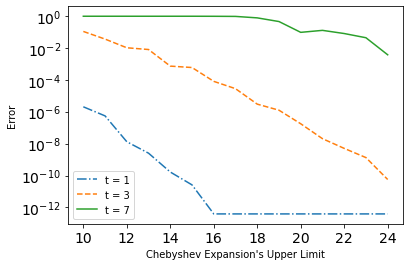

In [4]:
from qutip import *
from scipy.special import jv
import numpy as np
import matplotlib.pyplot as plt

si = qeye(2)

sx = sigmax()

sy = sigmay()

sz = sigmaz()

n = 1

m = 1

extmagfield_m = Qobj([[0, 0, 0], [0, 0, 0], [1, 1, 1]])

extmagfield_n = Qobj([[0, 0, 0], [0, 0, 0], [0.3, 0.3, 0.3]])

JJ = Qobj([[0, 0, 0], [0, 0, 0], [0, 0, 0]])

AA = Qobj([[0, 0, 0], [0, 0, 0], [0.99925, 0.625147, 0.551273]])
gama = Qobj(
    [
        [0.0124425, 0.0806628, 0.00999575],
        [0.0550028, 0.0758354, 0.07346340],
        [0.0972069, 0.0723954, 0.07405450],
    ]
)
E1 = (
    1 / 2 * sum(sum(sum(JJ)))
    + 1 / 2 * sum(sum(sum(gama)))
    + 1 / 2 * sum(sum(sum(AA)))
    + sum(sum(sum(extmagfield_m)))
    + sum(sum(sum(extmagfield_n)))
)
t = 1
tau = E1 * t / 2
kappa = 10


def spin_op(N):
    Sx = []
    Sy = []
    Sz = []

    for n in range(N):
        x_list = []
        y_list = []
        z_list = []

        for m in range(N):
            x_list.append(si)
            y_list.append(si)
            z_list.append(si)

        x_list[n] = sx
        y_list[n] = sy
        z_list[n] = sz

        Sx.append(tensor(x_list))
        Sy.append(tensor(y_list))
        Sz.append(tensor(z_list))

    return [Sx, Sy, Sz]


def hamiltonian():
    Sx, Sy, Sz = spin_op(m + n)
    HS = HB = V = 0
    for i in range(m):
        HS += (
            extmagfield_m[0, i] * Sx[i]
            + extmagfield_m[1, i] * Sy[i]
            + extmagfield_m[2, i] * Sz[i]
        )
        for j in range(m):
            HS += (
                JJ[0, j] * Sx[i] * Sx[j]
                + JJ[1, j] * Sy[i] * Sy[j]
                + JJ[2, j] * Sz[i] * Sz[j]
            )

    for i in range(m, m + n):
        HB += (
            extmagfield_n[0, i] * Sx[i]
            + extmagfield_n[1, i] * Sy[i]
            + extmagfield_n[2, i] * Sz[i]
        )
        for j in range(m, m + n):
            HB += (
                gama[0, j] * Sx[i] * Sx[j]
                + gama[1, j] * Sy[i] * Sy[j]
                + gama[2, j] * Sz[i] * Sz[j]
            )
    for i in range(m, m + n):
        for j in range(m):
            V += (
                AA[0, j] * Sx[i] * Sx[j]
                + AA[1, j] * Sy[i] * Sy[j]
                + AA[2, j] * Sz[i] * Sz[j]
            )
    HH = HS + HB + V
    return HH


HH = hamiltonian()
G = 2 * HH / E1
TG_list = [1, G]
a = TG_list[0]
b = TG_list[1]
for i in range(1000):
    c = (2 * G * b) - a
    a = b
    b = c
    TG_list.append(b)


def evo(tau, kappa):
    UU = 0
    for k in range(int(kappa) + 1):
        a = 2
        if k == 0:
            a = 1
        UU += a * ((-1j) ** k) * jv(k, tau) * TG_list[k]
    return UU


def test_time(t, kappa):
    result = {}
    for i in np.linspace(1, t, 30):
        tau = i * E1 / 2
        out = evo(tau, kappa)
        deter = abs(1 - abs(np.linalg.det(out)))
        print(f"for t = {i}, error is = {deter}")
        result[i] = deter
    plt.plot(list(result.keys()), list(result.values()), color="cyan")
    plt.title("Constant upper limit = 16")
    plt.xlabel("time")
    plt.ylabel("error")
    plt.yscale("log")
    plt.show()


def test_kappa(t, kappa):
    result = {}
    tau = t * E1 / 2
    for i in range(10, kappa):
        out = evo(tau, i)
        deter = abs(1 - abs(np.linalg.det(out)))
        print(f"for kappa = {i}, error is = {deter}")
        result[i] = deter
    plt.plot(list(result.keys()), list(result.values()), color="cyan")
    plt.title("Constant time = ns")
    plt.xlabel("kappa")
    plt.ylabel("error")
    plt.yscale("log")
    plt.show()


# test_time(6, 15)
# test_kappa(2, 150)
stylee = {"1": "-.", "3": "--", "7": "-"}
t_list = [1, 3, 7]
for t, l in zip(t_list, stylee):
    result = {}
    tau = t * E1 / 2
    for i in range(10, 25):
        out = evo(tau, i)
        out = out * out.dag()
        deter = abs(1 - abs(np.linalg.det(out)))
        result[i] = deter
    plt.plot(
        list(result.keys()), list(result.values()), stylee[str(t)], label=f"t = {t}"
    )
plt.legend()
plt.xlabel("Chebyshev Expansion's Upper Limit")
plt.ylabel("Error")
plt.yscale("log")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()



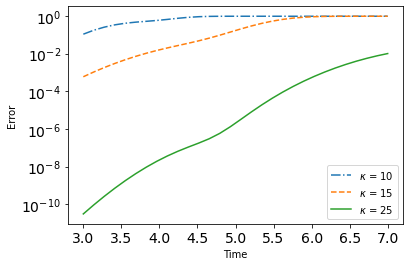

In [3]:
stylee = {"10": "-.", "15": "--", "25": "-"}
kap_list = [10, 15, 25]
for kap in kap_list:
    result = {}
    for i in np.linspace(3, 7, 30):
        tau = i * E1 / 2
        out = evo(tau, kap)
        out = out * out.dag()
        deter = abs(1 - abs(np.linalg.det(out)))
        result[i] = deter
    plt.plot(
        list(result.keys()),
        list(result.values()),
        stylee[str(kap)],
        label=f"$\kappa$ = {kap}",
    )
plt.legend()
plt.xlabel("Time")
plt.ylabel("Error")
plt.yscale("log")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()